### Final model - AdaBoost with RidgeRegression

In [77]:
import importlib
import helper_functions
import pandas as pd
importlib.reload(helper_functions)
from helper_functions import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV     

In [119]:
def create_sellingage(df):
    new_df = df.copy()
    new_df['SellingAge'] = new_df['YrSold'] - new_df['YearRemodAdd']
    return new_df

In [125]:
def combined_livingspace(df):
    new_df = df.copy()
    new_df['TotalSF'] = new_df['TotalBsmtSF'] + new_df['GrLivArea']
    return new_df

In [126]:
# Defining pipeline as in other examples
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X))),
    ('create_sellingage', DFTransform(lambda X: create_sellingage(X))),
    ('combined_livingspace', DFTransform(lambda X: combined_livingspace(X)))
    ])

In [127]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.933596634099
RMSE (log): 0.10183179698801262
Create predictions...(test)


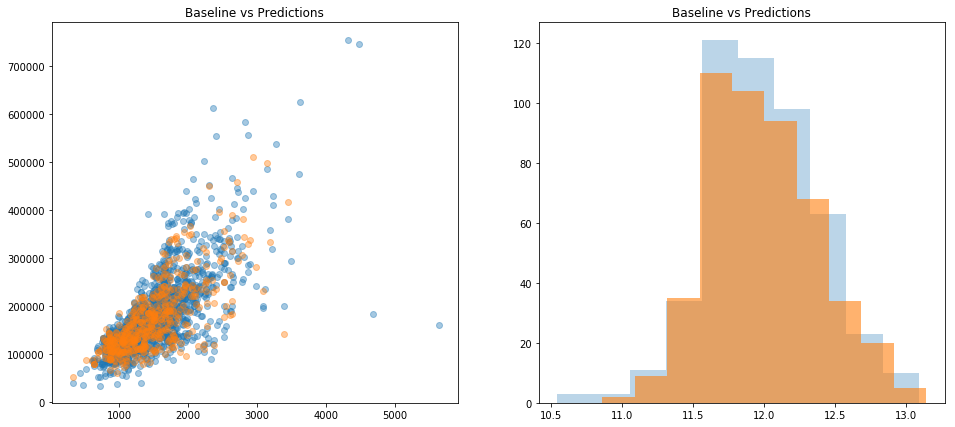

R2-score: 0.894634191377
RMSE (log): 0.12830253791025814
Fitting the pipeline to all the data...
Score: 0.92666961


In [128]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=1,
         random_state=42))]))